# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


Целевой признак
- Price — цена (евро)

## Подготовка данных

#### Импорт необходимых библиотек:

In [1]:
# pip install lightgbm

In [2]:
# pip install --upgrade pip setuptools wheel

In [3]:
# pip install catboost --no-binary :all:

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from catboost import CatBoostRegressor


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


state = RandomState(12345)

In [6]:
def rmse(predictions, targets): 
    return np.sqrt(((predictions - targets) ** 2).mean())

#### Загрузка датасета и основная информация:

In [7]:
data = pd.read_csv('autos.csv')

In [8]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [9]:
data.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [11]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<Axes: >

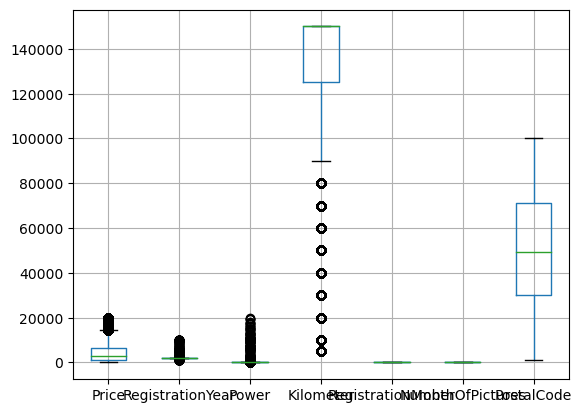

In [12]:
data.boxplot()

In [13]:
data.boxplot(['Price'])

<Axes: >

In [14]:
data.boxplot(['RegistrationYear'])

<Axes: >

In [15]:
data.boxplot(['Power'])

<Axes: >

In [16]:
data.boxplot(['Kilometer'])

<Axes: >

In [17]:
data.boxplot(['RegistrationMonth'])

<Axes: >

In [18]:
data.boxplot(['NumberOfPictures'])

<Axes: >

In [19]:
data.boxplot(['PostalCode'])

<Axes: >

In [20]:
data.hist(bins=50, figsize=(90,90));

In [21]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

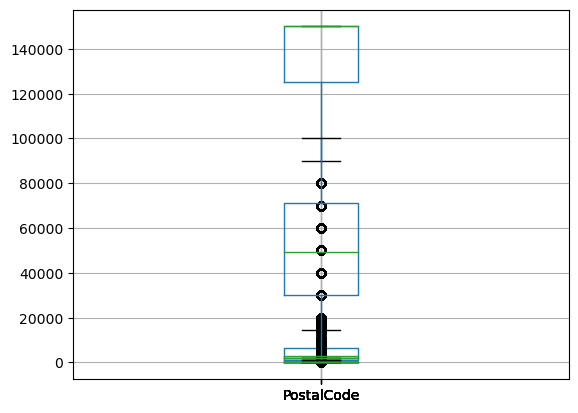

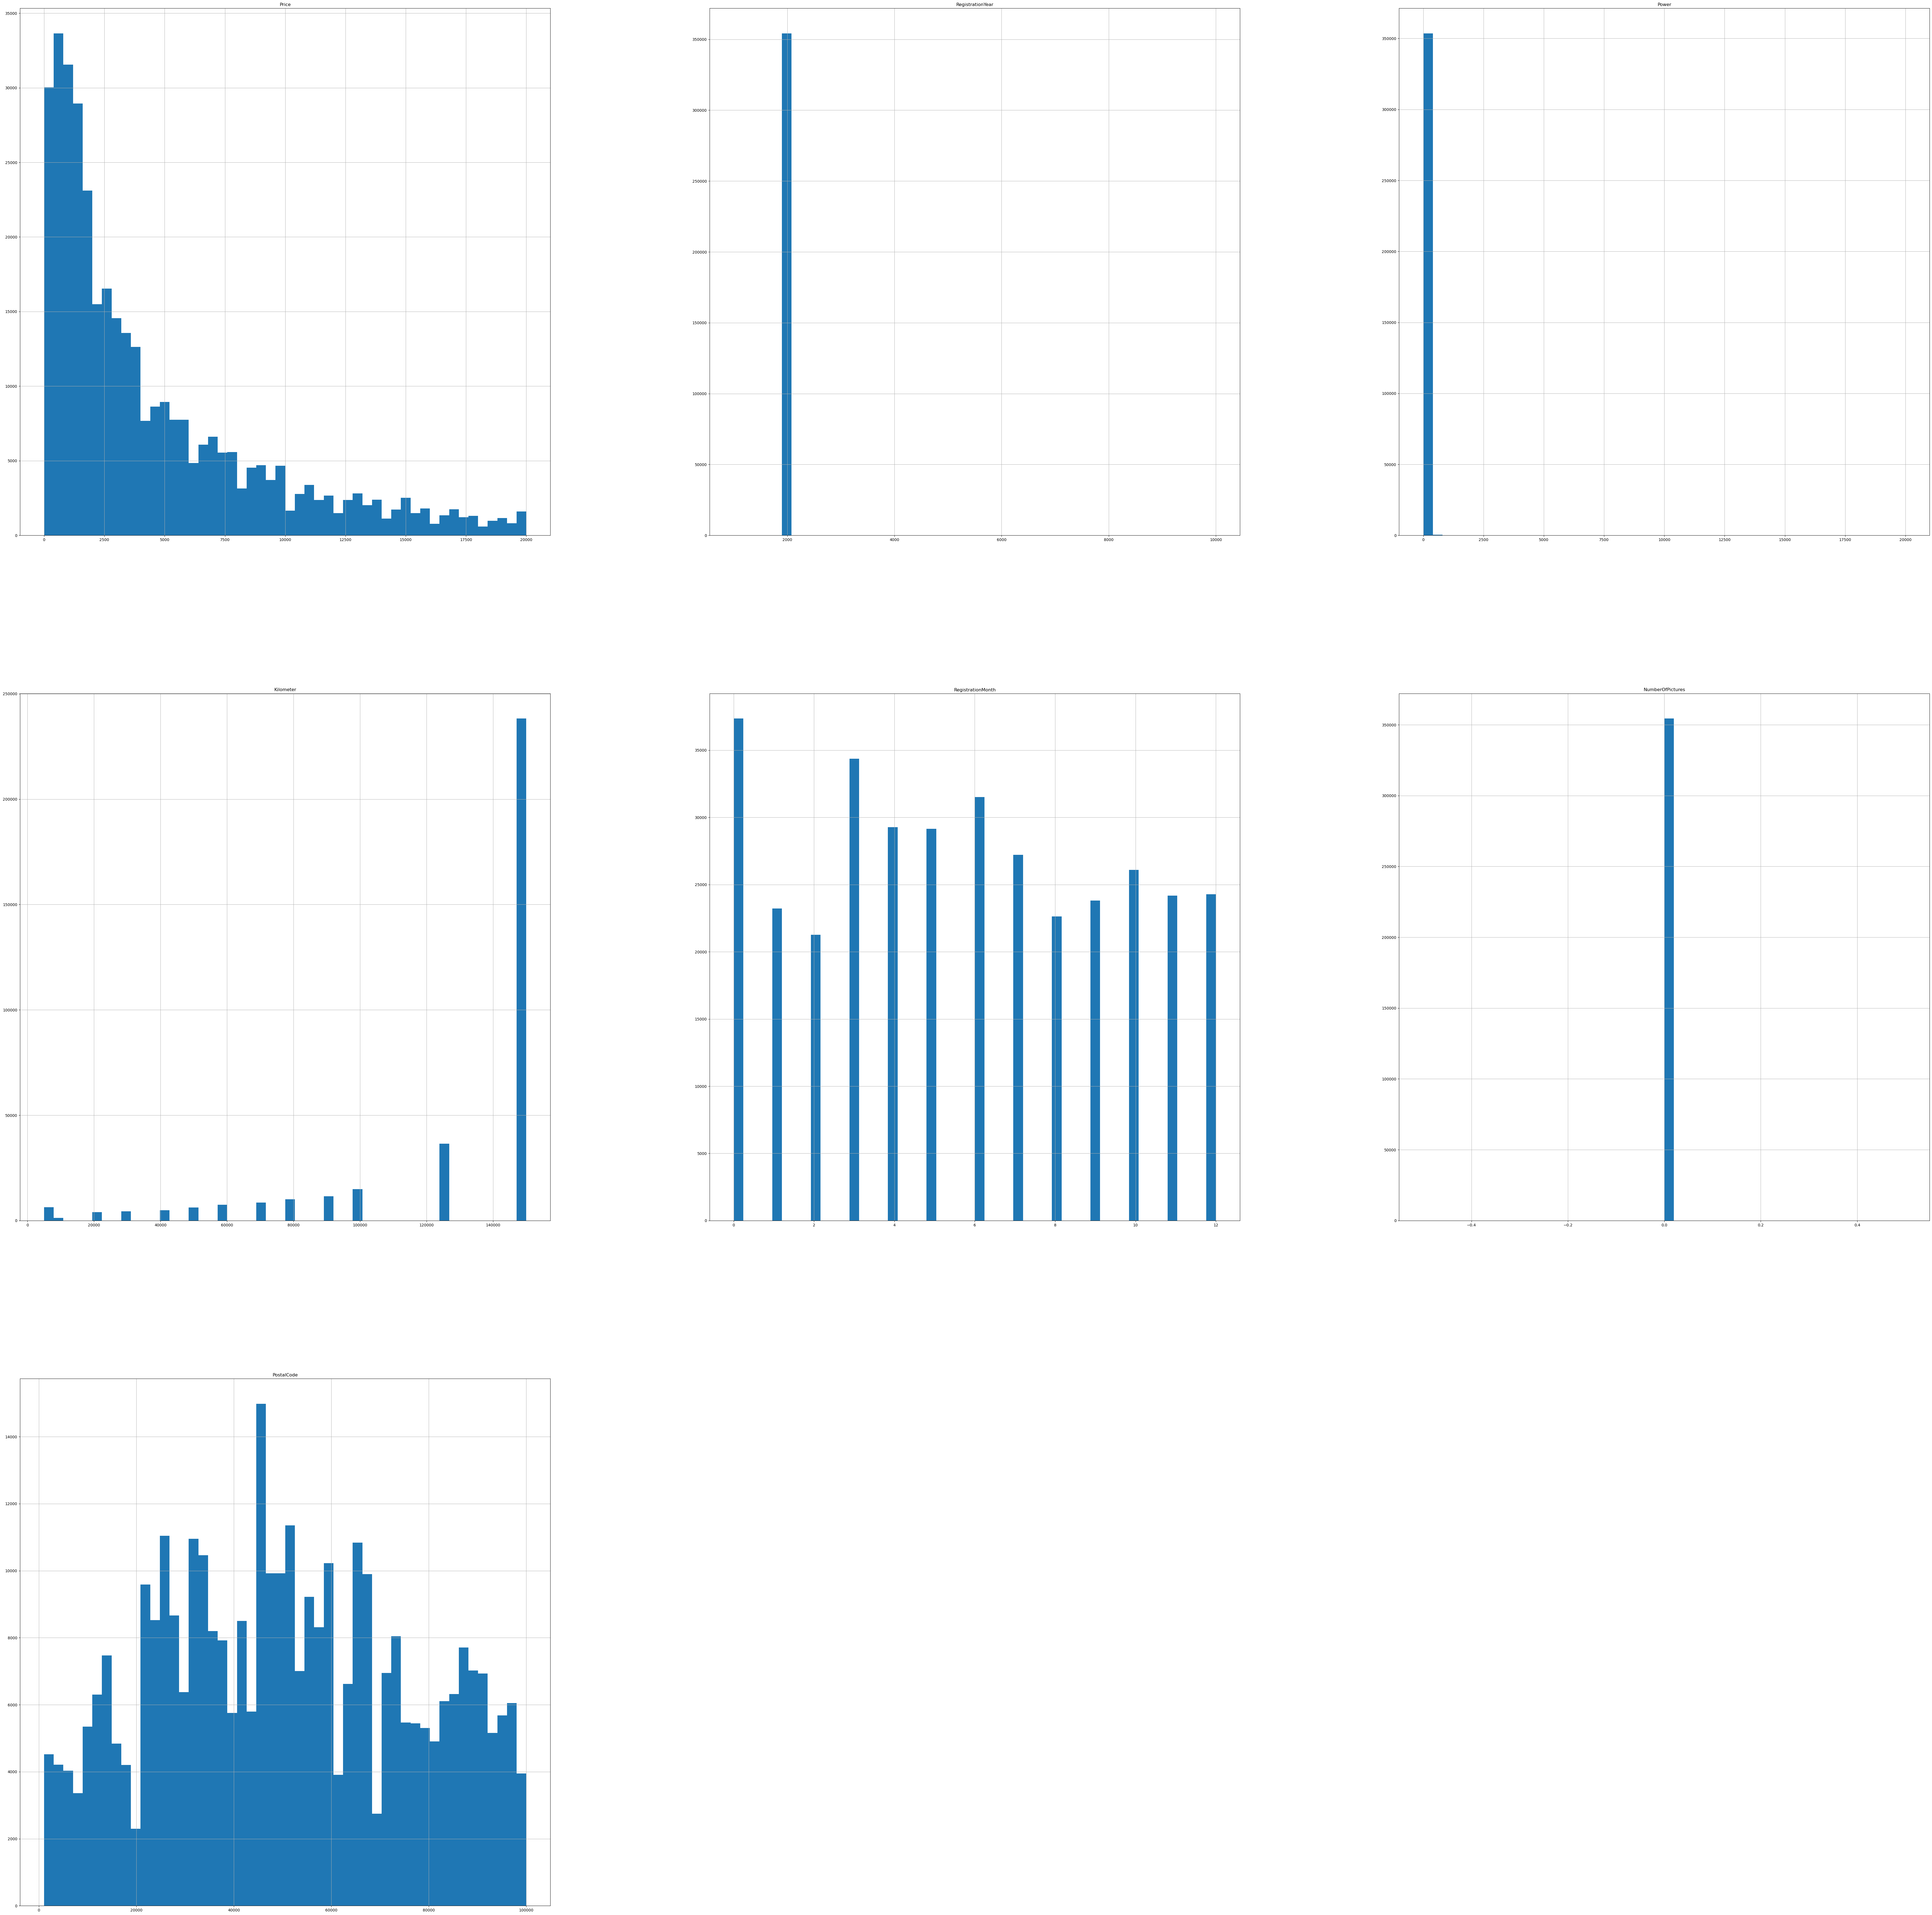

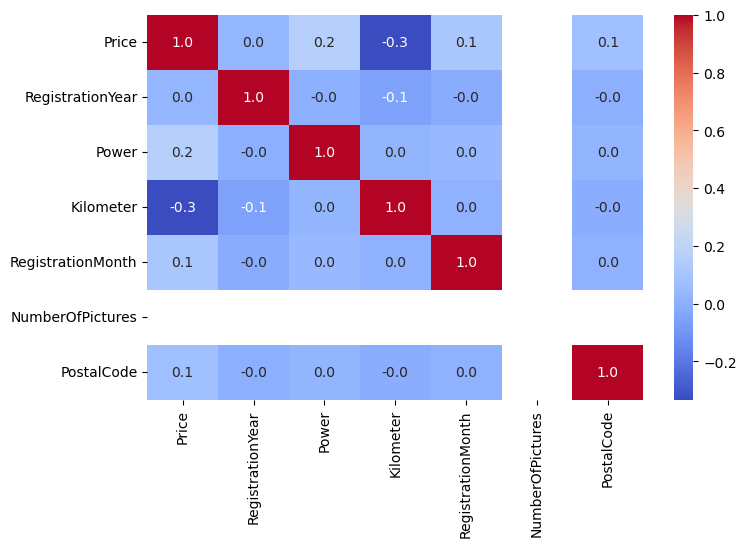

In [22]:
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(corr_matrix, cmap='coolwarm',annot=True, fmt='.1f', ax=ax)
plt.show()

#### Обработка выбросов.

Стоимость авто не может быть нулевой, год регистрации не может превышать текущий (2023), мощность не может превышать 2000 л.с. Удалим выбросы.

In [23]:
data = data[data['Price'] > 300]

In [24]:
data = data[data['RegistrationYear'] < 2017]

In [25]:
data = data[data['Power'] < 700]

#### Проверка на уникальные значения в столбце 'NumberOfPictures':

In [26]:
data['NumberOfPictures'].unique()

array([0])

Столбец не несет никакой смысловой и информационной нагрузки, удаляем вместе со столбцами дат.

In [27]:
data = data.drop(['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

#### Анализ пропусков пропусков и кодирование данных:

Для обучения базовых моделей требуется заполнить пропуски и кодировать категориальные признаки. Создадим копию датасета и будем работать с копией.

Пропусков в датасете много, поэтому заменим пропуски в категориальных данных на 'unknown'.

In [28]:
data_coding = data

In [29]:
data_coding.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314783 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              314783 non-null  int64 
 1   VehicleType        298901 non-null  object
 2   RegistrationYear   314783 non-null  int64 
 3   Gearbox            301990 non-null  object
 4   Power              314783 non-null  int64 
 5   Model              300931 non-null  object
 6   Kilometer          314783 non-null  int64 
 7   RegistrationMonth  314783 non-null  int64 
 8   FuelType           294615 non-null  object
 9   Brand              314783 non-null  object
 10  Repaired           261850 non-null  object
 11  PostalCode         314783 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 31.2+ MB


In [30]:
data_coding.isna().sum()

Price                    0
VehicleType          15882
RegistrationYear         0
Gearbox              12793
Power                    0
Model                13852
Kilometer                0
RegistrationMonth        0
FuelType             20168
Brand                    0
Repaired             52933
PostalCode               0
dtype: int64

Заменим пропуски на значение 'unknown'.

In [31]:
data_coding['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [32]:
data_coding['Repaired'] = data_coding['Repaired'].fillna(value='unknown_repared')

In [33]:
data_coding['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [34]:
data_coding['FuelType'] = data_coding['FuelType'].fillna(value='unknown_fueltype')

In [35]:
data_coding['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'polo',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', 'z_reihe', 'sorento', 'ibiza', 'mustang', 'eos', 'touran',
       'getz', 'a3', 'almera', 'megane', 'lupo', 'r19', 'caddy', 'mondeo',
       'cordoba', 'colt', 'impreza', 'vectra', 'berlingo', 'tiguan',
       'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er',
       'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio', 'touareg', 'logan',
       'spi

In [36]:
data_coding['Model'] = data_coding['Model'].fillna(value='unknown_model')

In [37]:
data_coding['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [38]:
data_coding['Gearbox'] = data_coding['Gearbox'].fillna(value='unknown_gearbox')

In [39]:
data_coding['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [40]:
data_coding['VehicleType'] = data_coding['VehicleType'].fillna(value='unknown_vehicletype')

#### Проверка на дубликаты.

In [41]:
data.duplicated().sum()

19531

In [42]:
data.drop_duplicates(inplace=True)

## Обучение моделей

Для обучения возьмем:
- Линейную регрессию
- Случайное дерево
- Случайный лес
- Градиентный бустинг

Линейную регрессию и Случайный лес будем обучать на закодированных признаках, а градиентный бустинг на исходном датасете и закодированном. 

Выделим 25% датасета в тестовую выборку.

In [43]:
features = data.drop('Price', axis=1)
target = data['Price']

In [44]:
features_valid,features_test, target_valid, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)   

In [45]:
features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((221439, 11), (221439,), (73813, 11), (73813,))

#### Кодирование признаков:

In [46]:
features_valid_coding = pd.get_dummies(features_valid, columns=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], drop_first= True)

In [47]:
features_test_coding = pd.get_dummies(features_test, columns=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], drop_first= True)

In [48]:
features_valid_coding.shape, target_valid.shape, features_test_coding.shape, target_test.shape

((221439, 312), (221439,), (73813, 309), (73813,))

In [49]:
columns_valid = features_valid_coding.columns
columns_test = features_test_coding.columns
columns_two = []
for i in columns_valid:
    for j in columns_test:
        if i == j:
            columns_two.append(i)
len(columns_two)

308

In [50]:
features_valid_nan = features_valid_coding.columns.drop(columns_two)
features_test_nan = features_test_coding.columns.drop(columns_two)

features_valid_coding = features_valid_coding.drop(features_valid_nan, axis=1)
features_test_coding = features_test_coding.drop(features_test_nan, axis=1)


In [51]:
features_valid_coding.shape, target_valid.shape, features_test_coding.shape, target_test.shape

((221439, 308), (221439,), (73813, 308), (73813,))

Для интерпритации результата заказчик просит применять RMSE, обучим линейные модели с параметром scoring='neg_mean_absolute_error'.

### Линейная регрессия

In [52]:
%%time
model_linear = LinearRegression()

scores = -1 * cross_val_score(model_linear, features_valid_coding, target_valid, scoring='neg_mean_absolute_error', cv=5)
final_score = scores.mean()
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 2056.4731201540867
CPU times: user 41.1 s, sys: 5.21 s, total: 46.3 s
Wall time: 19.6 s


### Случайное дерево

In [53]:
%%time

best_model_three = 0
best_depth = 0
best_score = 3500

for depth in range(18, 19):
    model_three = DecisionTreeRegressor(max_depth=depth)
    scores = -1 * cross_val_score(
        model_three, features_valid_coding, target_valid, 
        scoring='neg_mean_absolute_error', cv=5
    )
    final_score = scores.mean()
    if final_score < best_score:
        best_score = final_score
        best_depth = depth
        best_model_three = model_three
        

print('Средняя оценка качества модели:', best_score)
best_model_three

Средняя оценка качества модели: 1205.005825795481
CPU times: user 18.3 s, sys: 1.31 s, total: 19.7 s
Wall time: 19.4 s


DecisionTreeRegressor(max_depth=18)

### Случайный лес

In [54]:
%%time


best_depth_forest = 0
best_est_forest = 0
best_forest_score = 1500

for est in range(14, 15):
    for depth in range (18, 19):
        model_forest = RandomForestRegressor(n_estimators=est, max_depth=depth)
        scores = -1 * cross_val_score(
            model_forest, features_valid_coding, target_valid, 
            scoring='neg_mean_absolute_error', cv=5
        )
        final_score = scores.mean()
        if final_score < best_forest_score:
            best_forest_score = final_score
            best_est_forest = est
            best_depth_forest = depth
            
forest_best = {'depth': best_depth_forest, 'n_estimators': best_est_forest}
print('Средняя оценка качества модели:', best_forest_score)
forest_best

Средняя оценка качества модели: 1079.3354215678046
CPU times: user 2min 28s, sys: 1.59 s, total: 2min 30s
Wall time: 2min 30s


{'depth': 18, 'n_estimators': 14}

###  LGBMRegressor

In [55]:
%%time

lgb_model = lgb.LGBMRegressor()
lgb_score = - cross_val_score(lgb_model,features_valid_coding, target_valid,
                              scoring='neg_mean_absolute_error', cv=5)
lgb_score.mean()

CPU times: user 36.6 s, sys: 2.07 s, total: 38.6 s
Wall time: 8.21 s


1089.752424042616

Становится понятно, что для задачи нашего заказчика лучше использовать модель случайного дерева. Она, хоть и уступает в точности случаному лесу и lgb, но работает весьма быстро. И точность вполне укладывается в заданную заказчиком.

## CatBoost

In [56]:
%%time

cb_model = CatBoostRegressor(learning_rate=0.1, random_state=12345)
cb_score = - cross_val_score(cb_model, features_valid_coding, target_valid, 
                             scoring='neg_mean_absolute_error', cv=5)
cb_score.mean()

0:	learn: 4248.4406891	total: 77.9ms	remaining: 1m 17s
1:	learn: 3996.2858877	total: 89ms	remaining: 44.4s
2:	learn: 3770.4225674	total: 97.7ms	remaining: 32.5s
3:	learn: 3577.5364541	total: 106ms	remaining: 26.5s
4:	learn: 3407.0263780	total: 114ms	remaining: 22.7s
5:	learn: 3255.4412073	total: 123ms	remaining: 20.3s
6:	learn: 3121.7354189	total: 130ms	remaining: 18.5s
7:	learn: 3000.2085849	total: 137ms	remaining: 17s
8:	learn: 2897.7764577	total: 143ms	remaining: 15.8s
9:	learn: 2808.9990690	total: 149ms	remaining: 14.8s
10:	learn: 2728.9551855	total: 156ms	remaining: 14.1s
11:	learn: 2656.9056742	total: 163ms	remaining: 13.4s
12:	learn: 2592.7230359	total: 170ms	remaining: 12.9s
13:	learn: 2538.8212403	total: 176ms	remaining: 12.4s
14:	learn: 2489.8684126	total: 182ms	remaining: 12s
15:	learn: 2443.9131229	total: 188ms	remaining: 11.6s
16:	learn: 2406.0476175	total: 195ms	remaining: 11.3s
17:	learn: 2373.8351180	total: 201ms	remaining: 11s
18:	learn: 2339.8590279	total: 209ms	remai

152:	learn: 1768.7675742	total: 1.08s	remaining: 5.99s
153:	learn: 1767.9035392	total: 1.09s	remaining: 5.98s
154:	learn: 1767.3643369	total: 1.09s	remaining: 5.97s
155:	learn: 1766.2296805	total: 1.1s	remaining: 5.97s
156:	learn: 1765.5481298	total: 1.11s	remaining: 5.96s
157:	learn: 1764.8257720	total: 1.12s	remaining: 5.96s
158:	learn: 1764.2239631	total: 1.13s	remaining: 5.95s
159:	learn: 1763.4982526	total: 1.13s	remaining: 5.95s
160:	learn: 1762.4859295	total: 1.14s	remaining: 5.94s
161:	learn: 1761.8000721	total: 1.15s	remaining: 5.94s
162:	learn: 1761.1407849	total: 1.16s	remaining: 5.94s
163:	learn: 1760.2367214	total: 1.16s	remaining: 5.93s
164:	learn: 1759.2699890	total: 1.17s	remaining: 5.93s
165:	learn: 1758.7163788	total: 1.18s	remaining: 5.92s
166:	learn: 1758.0202045	total: 1.18s	remaining: 5.9s
167:	learn: 1756.7418911	total: 1.19s	remaining: 5.89s
168:	learn: 1756.1275172	total: 1.19s	remaining: 5.88s
169:	learn: 1755.2225362	total: 1.2s	remaining: 5.86s
170:	learn: 1

304:	learn: 1680.7297072	total: 2.08s	remaining: 4.74s
305:	learn: 1680.4803350	total: 2.08s	remaining: 4.73s
306:	learn: 1679.8833691	total: 2.09s	remaining: 4.72s
307:	learn: 1679.5814392	total: 2.1s	remaining: 4.72s
308:	learn: 1678.9608131	total: 2.11s	remaining: 4.71s
309:	learn: 1678.6745268	total: 2.11s	remaining: 4.71s
310:	learn: 1678.2985243	total: 2.12s	remaining: 4.7s
311:	learn: 1677.6127706	total: 2.13s	remaining: 4.7s
312:	learn: 1677.0336050	total: 2.14s	remaining: 4.69s
313:	learn: 1676.3956866	total: 2.15s	remaining: 4.69s
314:	learn: 1676.0976030	total: 2.15s	remaining: 4.68s
315:	learn: 1675.8559410	total: 2.16s	remaining: 4.68s
316:	learn: 1675.3964966	total: 2.17s	remaining: 4.67s
317:	learn: 1675.1407264	total: 2.17s	remaining: 4.66s
318:	learn: 1674.7529150	total: 2.18s	remaining: 4.65s
319:	learn: 1674.1288823	total: 2.19s	remaining: 4.64s
320:	learn: 1673.5457647	total: 2.19s	remaining: 4.63s
321:	learn: 1673.2472519	total: 2.2s	remaining: 4.63s
322:	learn: 16

462:	learn: 1632.9135706	total: 3.08s	remaining: 3.57s
463:	learn: 1632.7303854	total: 3.09s	remaining: 3.56s
464:	learn: 1632.4859728	total: 3.09s	remaining: 3.56s
465:	learn: 1632.0040702	total: 3.1s	remaining: 3.55s
466:	learn: 1631.7895078	total: 3.11s	remaining: 3.55s
467:	learn: 1631.5304822	total: 3.12s	remaining: 3.54s
468:	learn: 1631.3897242	total: 3.12s	remaining: 3.54s
469:	learn: 1630.9939816	total: 3.13s	remaining: 3.53s
470:	learn: 1630.7897363	total: 3.14s	remaining: 3.53s
471:	learn: 1630.4590061	total: 3.15s	remaining: 3.52s
472:	learn: 1630.0491479	total: 3.15s	remaining: 3.52s
473:	learn: 1629.8023994	total: 3.16s	remaining: 3.51s
474:	learn: 1629.6105180	total: 3.17s	remaining: 3.5s
475:	learn: 1629.3685487	total: 3.17s	remaining: 3.49s
476:	learn: 1629.1324975	total: 3.18s	remaining: 3.48s
477:	learn: 1628.8404449	total: 3.18s	remaining: 3.48s
478:	learn: 1628.7341062	total: 3.19s	remaining: 3.47s
479:	learn: 1628.5096288	total: 3.19s	remaining: 3.46s
480:	learn: 

621:	learn: 1598.7621498	total: 4.08s	remaining: 2.48s
622:	learn: 1598.5410009	total: 4.08s	remaining: 2.47s
623:	learn: 1598.3724869	total: 4.09s	remaining: 2.46s
624:	learn: 1598.2333420	total: 4.09s	remaining: 2.46s
625:	learn: 1598.0909303	total: 4.1s	remaining: 2.45s
626:	learn: 1597.7703248	total: 4.11s	remaining: 2.44s
627:	learn: 1597.6097305	total: 4.12s	remaining: 2.44s
628:	learn: 1597.3508189	total: 4.13s	remaining: 2.43s
629:	learn: 1597.2105522	total: 4.13s	remaining: 2.43s
630:	learn: 1596.9946276	total: 4.14s	remaining: 2.42s
631:	learn: 1596.8983244	total: 4.15s	remaining: 2.42s
632:	learn: 1596.6441126	total: 4.16s	remaining: 2.41s
633:	learn: 1596.4145969	total: 4.16s	remaining: 2.4s
634:	learn: 1596.2195037	total: 4.17s	remaining: 2.4s
635:	learn: 1596.0213640	total: 4.17s	remaining: 2.39s
636:	learn: 1595.7691368	total: 4.18s	remaining: 2.38s
637:	learn: 1595.5277435	total: 4.19s	remaining: 2.38s
638:	learn: 1595.3825393	total: 4.19s	remaining: 2.37s
639:	learn: 1

773:	learn: 1573.8991085	total: 5.07s	remaining: 1.48s
774:	learn: 1573.7412697	total: 5.08s	remaining: 1.47s
775:	learn: 1573.5140418	total: 5.09s	remaining: 1.47s
776:	learn: 1573.3697599	total: 5.09s	remaining: 1.46s
777:	learn: 1573.2412938	total: 5.1s	remaining: 1.46s
778:	learn: 1573.0953870	total: 5.11s	remaining: 1.45s
779:	learn: 1572.9813177	total: 5.12s	remaining: 1.44s
780:	learn: 1572.8675224	total: 5.13s	remaining: 1.44s
781:	learn: 1572.7627936	total: 5.13s	remaining: 1.43s
782:	learn: 1572.6068990	total: 5.14s	remaining: 1.43s
783:	learn: 1572.5265970	total: 5.15s	remaining: 1.42s
784:	learn: 1572.2731589	total: 5.16s	remaining: 1.41s
785:	learn: 1572.1748856	total: 5.16s	remaining: 1.41s
786:	learn: 1572.0509288	total: 5.17s	remaining: 1.4s
787:	learn: 1571.7960225	total: 5.18s	remaining: 1.39s
788:	learn: 1571.7044094	total: 5.18s	remaining: 1.39s
789:	learn: 1571.4883845	total: 5.19s	remaining: 1.38s
790:	learn: 1571.2742013	total: 5.2s	remaining: 1.37s
791:	learn: 1

924:	learn: 1553.3699449	total: 6.27s	remaining: 508ms
925:	learn: 1553.3310184	total: 6.28s	remaining: 502ms
926:	learn: 1553.2491379	total: 6.28s	remaining: 495ms
927:	learn: 1553.1139486	total: 6.29s	remaining: 488ms
928:	learn: 1553.0195803	total: 6.3s	remaining: 482ms
929:	learn: 1552.9637432	total: 6.31s	remaining: 475ms
930:	learn: 1552.8776121	total: 6.32s	remaining: 468ms
931:	learn: 1552.7733044	total: 6.33s	remaining: 462ms
932:	learn: 1552.5738017	total: 6.33s	remaining: 455ms
933:	learn: 1552.4456419	total: 6.34s	remaining: 448ms
934:	learn: 1552.3478825	total: 6.35s	remaining: 441ms
935:	learn: 1552.3055970	total: 6.36s	remaining: 435ms
936:	learn: 1552.1823632	total: 6.37s	remaining: 428ms
937:	learn: 1552.0746035	total: 6.37s	remaining: 421ms
938:	learn: 1551.9276921	total: 6.38s	remaining: 414ms
939:	learn: 1551.7451828	total: 6.39s	remaining: 408ms
940:	learn: 1551.6416690	total: 6.4s	remaining: 401ms
941:	learn: 1551.5040703	total: 6.4s	remaining: 394ms
942:	learn: 1

89:	learn: 1837.4517567	total: 601ms	remaining: 6.07s
90:	learn: 1836.2879720	total: 607ms	remaining: 6.06s
91:	learn: 1834.6665224	total: 613ms	remaining: 6.05s
92:	learn: 1833.5438691	total: 619ms	remaining: 6.04s
93:	learn: 1831.6795007	total: 626ms	remaining: 6.03s
94:	learn: 1828.7322347	total: 633ms	remaining: 6.03s
95:	learn: 1827.3177818	total: 640ms	remaining: 6.03s
96:	learn: 1825.3972954	total: 648ms	remaining: 6.04s
97:	learn: 1824.3146032	total: 656ms	remaining: 6.04s
98:	learn: 1823.3052071	total: 664ms	remaining: 6.04s
99:	learn: 1822.2064462	total: 670ms	remaining: 6.03s
100:	learn: 1819.8574062	total: 679ms	remaining: 6.04s
101:	learn: 1818.3957827	total: 686ms	remaining: 6.04s
102:	learn: 1817.4052778	total: 693ms	remaining: 6.03s
103:	learn: 1816.0414970	total: 700ms	remaining: 6.03s
104:	learn: 1814.7717553	total: 706ms	remaining: 6.01s
105:	learn: 1813.8519957	total: 712ms	remaining: 6s
106:	learn: 1812.7481549	total: 717ms	remaining: 5.99s
107:	learn: 1811.2056498

247:	learn: 1695.6870105	total: 1.6s	remaining: 4.85s
248:	learn: 1695.2171584	total: 1.61s	remaining: 4.85s
249:	learn: 1694.5115086	total: 1.61s	remaining: 4.84s
250:	learn: 1693.8841142	total: 1.62s	remaining: 4.84s
251:	learn: 1693.5532790	total: 1.63s	remaining: 4.83s
252:	learn: 1693.1219011	total: 1.64s	remaining: 4.83s
253:	learn: 1692.8439009	total: 1.64s	remaining: 4.83s
254:	learn: 1692.4621721	total: 1.65s	remaining: 4.83s
255:	learn: 1692.0425439	total: 1.66s	remaining: 4.83s
256:	learn: 1691.7819153	total: 1.67s	remaining: 4.82s
257:	learn: 1691.2203422	total: 1.68s	remaining: 4.82s
258:	learn: 1690.6633336	total: 1.68s	remaining: 4.82s
259:	learn: 1690.2798907	total: 1.69s	remaining: 4.81s
260:	learn: 1689.7995039	total: 1.7s	remaining: 4.81s
261:	learn: 1689.5375519	total: 1.7s	remaining: 4.8s
262:	learn: 1688.9708289	total: 1.71s	remaining: 4.79s
263:	learn: 1688.5607895	total: 1.71s	remaining: 4.78s
264:	learn: 1688.1219688	total: 1.72s	remaining: 4.77s
265:	learn: 16

401:	learn: 1640.7622948	total: 2.6s	remaining: 3.86s
402:	learn: 1640.5657900	total: 2.6s	remaining: 3.86s
403:	learn: 1640.2227753	total: 2.61s	remaining: 3.85s
404:	learn: 1639.8744832	total: 2.62s	remaining: 3.85s
405:	learn: 1639.6517347	total: 2.62s	remaining: 3.84s
406:	learn: 1639.4697654	total: 2.63s	remaining: 3.83s
407:	learn: 1639.1211980	total: 2.64s	remaining: 3.83s
408:	learn: 1638.7269889	total: 2.65s	remaining: 3.83s
409:	learn: 1638.4344227	total: 2.65s	remaining: 3.82s
410:	learn: 1638.2409631	total: 2.66s	remaining: 3.81s
411:	learn: 1637.8419965	total: 2.67s	remaining: 3.81s
412:	learn: 1637.5306769	total: 2.68s	remaining: 3.81s
413:	learn: 1637.0812392	total: 2.68s	remaining: 3.8s
414:	learn: 1636.6712924	total: 2.69s	remaining: 3.79s
415:	learn: 1636.4750081	total: 2.7s	remaining: 3.79s
416:	learn: 1636.2867421	total: 2.7s	remaining: 3.78s
417:	learn: 1636.0537973	total: 2.71s	remaining: 3.77s
418:	learn: 1635.8391127	total: 2.71s	remaining: 3.76s
419:	learn: 163

558:	learn: 1604.5162175	total: 3.59s	remaining: 2.83s
559:	learn: 1604.2841053	total: 3.6s	remaining: 2.83s
560:	learn: 1603.9653879	total: 3.6s	remaining: 2.82s
561:	learn: 1603.7624623	total: 3.61s	remaining: 2.81s
562:	learn: 1603.5809313	total: 3.62s	remaining: 2.81s
563:	learn: 1603.4145572	total: 3.62s	remaining: 2.8s
564:	learn: 1603.1334770	total: 3.63s	remaining: 2.79s
565:	learn: 1603.0021361	total: 3.64s	remaining: 2.79s
566:	learn: 1602.8314220	total: 3.65s	remaining: 2.78s
567:	learn: 1602.6513318	total: 3.65s	remaining: 2.78s
568:	learn: 1602.5476926	total: 3.66s	remaining: 2.77s
569:	learn: 1602.3528780	total: 3.67s	remaining: 2.77s
570:	learn: 1602.1858746	total: 3.67s	remaining: 2.76s
571:	learn: 1602.0844712	total: 3.68s	remaining: 2.75s
572:	learn: 1601.9929269	total: 3.69s	remaining: 2.75s
573:	learn: 1601.8364075	total: 3.69s	remaining: 2.74s
574:	learn: 1601.4974638	total: 3.7s	remaining: 2.73s
575:	learn: 1601.3169768	total: 3.7s	remaining: 2.73s
576:	learn: 160

715:	learn: 1577.5000900	total: 4.59s	remaining: 1.82s
716:	learn: 1577.2984649	total: 4.59s	remaining: 1.81s
717:	learn: 1577.0900108	total: 4.6s	remaining: 1.81s
718:	learn: 1576.9665173	total: 4.61s	remaining: 1.8s
719:	learn: 1576.8581651	total: 4.61s	remaining: 1.79s
720:	learn: 1576.7506523	total: 4.62s	remaining: 1.79s
721:	learn: 1576.6703572	total: 4.63s	remaining: 1.78s
722:	learn: 1576.5656560	total: 4.63s	remaining: 1.77s
723:	learn: 1576.3163371	total: 4.64s	remaining: 1.77s
724:	learn: 1576.1995205	total: 4.65s	remaining: 1.76s
725:	learn: 1576.0751613	total: 4.66s	remaining: 1.76s
726:	learn: 1575.9041296	total: 4.66s	remaining: 1.75s
727:	learn: 1575.7524090	total: 4.67s	remaining: 1.74s
728:	learn: 1575.5589644	total: 4.68s	remaining: 1.74s
729:	learn: 1575.4056630	total: 4.68s	remaining: 1.73s
730:	learn: 1575.2186039	total: 4.69s	remaining: 1.73s
731:	learn: 1575.0498568	total: 4.7s	remaining: 1.72s
732:	learn: 1574.9615188	total: 4.7s	remaining: 1.71s
733:	learn: 15

868:	learn: 1555.5600370	total: 5.58s	remaining: 842ms
869:	learn: 1555.4049317	total: 5.59s	remaining: 836ms
870:	learn: 1555.2909240	total: 5.6s	remaining: 829ms
871:	learn: 1555.1298684	total: 5.61s	remaining: 823ms
872:	learn: 1555.0096557	total: 5.61s	remaining: 817ms
873:	learn: 1554.8660101	total: 5.62s	remaining: 810ms
874:	learn: 1554.7204598	total: 5.63s	remaining: 804ms
875:	learn: 1554.6095718	total: 5.64s	remaining: 798ms
876:	learn: 1554.4840234	total: 5.64s	remaining: 792ms
877:	learn: 1554.3831194	total: 5.65s	remaining: 785ms
878:	learn: 1554.2922371	total: 5.66s	remaining: 779ms
879:	learn: 1554.1451903	total: 5.67s	remaining: 773ms
880:	learn: 1554.0307885	total: 5.67s	remaining: 766ms
881:	learn: 1553.9085467	total: 5.68s	remaining: 760ms
882:	learn: 1553.8194764	total: 5.68s	remaining: 753ms
883:	learn: 1553.6826854	total: 5.69s	remaining: 747ms
884:	learn: 1553.6075510	total: 5.7s	remaining: 740ms
885:	learn: 1553.4201733	total: 5.7s	remaining: 734ms
886:	learn: 1

24:	learn: 2193.8088490	total: 216ms	remaining: 8.41s
25:	learn: 2176.0111022	total: 224ms	remaining: 8.39s
26:	learn: 2154.4320512	total: 233ms	remaining: 8.39s
27:	learn: 2137.0793909	total: 242ms	remaining: 8.39s
28:	learn: 2121.7738207	total: 250ms	remaining: 8.38s
29:	learn: 2108.4734832	total: 259ms	remaining: 8.39s
30:	learn: 2095.8960756	total: 268ms	remaining: 8.38s
31:	learn: 2084.4275683	total: 277ms	remaining: 8.38s
32:	learn: 2074.4058345	total: 285ms	remaining: 8.35s
33:	learn: 2065.5931256	total: 293ms	remaining: 8.32s
34:	learn: 2056.6904523	total: 301ms	remaining: 8.29s
35:	learn: 2044.4380113	total: 309ms	remaining: 8.28s
36:	learn: 2037.0057782	total: 317ms	remaining: 8.25s
37:	learn: 2029.4599107	total: 325ms	remaining: 8.23s
38:	learn: 2021.4110444	total: 333ms	remaining: 8.21s
39:	learn: 2014.4128093	total: 341ms	remaining: 8.19s
40:	learn: 2007.6327656	total: 349ms	remaining: 8.17s
41:	learn: 2000.0896739	total: 358ms	remaining: 8.15s
42:	learn: 1994.5855914	tota

180:	learn: 1743.8016982	total: 1.42s	remaining: 6.41s
181:	learn: 1742.5847284	total: 1.42s	remaining: 6.4s
182:	learn: 1741.9017880	total: 1.43s	remaining: 6.39s
183:	learn: 1741.1079381	total: 1.44s	remaining: 6.38s
184:	learn: 1740.6234823	total: 1.45s	remaining: 6.37s
185:	learn: 1740.1876662	total: 1.45s	remaining: 6.36s
186:	learn: 1739.3100589	total: 1.46s	remaining: 6.36s
187:	learn: 1738.8378795	total: 1.47s	remaining: 6.35s
188:	learn: 1738.3297846	total: 1.48s	remaining: 6.34s
189:	learn: 1737.3602676	total: 1.49s	remaining: 6.33s
190:	learn: 1736.6208400	total: 1.49s	remaining: 6.33s
191:	learn: 1736.0118160	total: 1.5s	remaining: 6.32s
192:	learn: 1735.0309617	total: 1.51s	remaining: 6.31s
193:	learn: 1734.1042367	total: 1.51s	remaining: 6.29s
194:	learn: 1733.3164150	total: 1.52s	remaining: 6.28s
195:	learn: 1732.5973428	total: 1.53s	remaining: 6.26s
196:	learn: 1732.0090540	total: 1.53s	remaining: 6.25s
197:	learn: 1731.3720591	total: 1.54s	remaining: 6.23s
198:	learn: 

337:	learn: 1664.5942212	total: 2.42s	remaining: 4.74s
338:	learn: 1664.2435230	total: 2.42s	remaining: 4.73s
339:	learn: 1663.9744765	total: 2.43s	remaining: 4.72s
340:	learn: 1663.7418829	total: 2.44s	remaining: 4.71s
341:	learn: 1663.4780640	total: 2.44s	remaining: 4.7s
342:	learn: 1663.1237172	total: 2.45s	remaining: 4.7s
343:	learn: 1662.8602560	total: 2.46s	remaining: 4.69s
344:	learn: 1662.7084041	total: 2.47s	remaining: 4.68s
345:	learn: 1662.3738959	total: 2.47s	remaining: 4.68s
346:	learn: 1662.0832106	total: 2.48s	remaining: 4.67s
347:	learn: 1661.6095532	total: 2.49s	remaining: 4.66s
348:	learn: 1661.2735927	total: 2.5s	remaining: 4.65s
349:	learn: 1660.8918184	total: 2.5s	remaining: 4.65s
350:	learn: 1660.6512531	total: 2.51s	remaining: 4.64s
351:	learn: 1660.2993229	total: 2.51s	remaining: 4.63s
352:	learn: 1660.0116040	total: 2.52s	remaining: 4.62s
353:	learn: 1659.7805139	total: 2.52s	remaining: 4.61s
354:	learn: 1659.5805856	total: 2.53s	remaining: 4.6s
355:	learn: 165

493:	learn: 1623.2201075	total: 3.41s	remaining: 3.5s
494:	learn: 1623.0850972	total: 3.42s	remaining: 3.49s
495:	learn: 1622.9525586	total: 3.43s	remaining: 3.48s
496:	learn: 1622.8084409	total: 3.44s	remaining: 3.48s
497:	learn: 1622.6834124	total: 3.44s	remaining: 3.47s
498:	learn: 1622.5200467	total: 3.45s	remaining: 3.46s
499:	learn: 1622.1159290	total: 3.46s	remaining: 3.46s
500:	learn: 1621.8746408	total: 3.46s	remaining: 3.45s
501:	learn: 1621.6323561	total: 3.47s	remaining: 3.44s
502:	learn: 1621.4518521	total: 3.48s	remaining: 3.44s
503:	learn: 1621.1825231	total: 3.49s	remaining: 3.43s
504:	learn: 1620.7662116	total: 3.5s	remaining: 3.43s
505:	learn: 1620.5100254	total: 3.5s	remaining: 3.42s
506:	learn: 1620.3089245	total: 3.51s	remaining: 3.41s
507:	learn: 1620.1464992	total: 3.52s	remaining: 3.4s
508:	learn: 1620.0353669	total: 3.52s	remaining: 3.4s
509:	learn: 1619.8287324	total: 3.53s	remaining: 3.39s
510:	learn: 1619.5996661	total: 3.53s	remaining: 3.38s
511:	learn: 161

645:	learn: 1592.6760370	total: 4.42s	remaining: 2.42s
646:	learn: 1592.5353439	total: 4.42s	remaining: 2.41s
647:	learn: 1592.3999061	total: 4.43s	remaining: 2.41s
648:	learn: 1592.2936456	total: 4.44s	remaining: 2.4s
649:	learn: 1592.1237578	total: 4.44s	remaining: 2.39s
650:	learn: 1592.0297267	total: 4.45s	remaining: 2.39s
651:	learn: 1591.6706822	total: 4.46s	remaining: 2.38s
652:	learn: 1591.4890561	total: 4.47s	remaining: 2.37s
653:	learn: 1591.2875488	total: 4.47s	remaining: 2.37s
654:	learn: 1591.1459176	total: 4.48s	remaining: 2.36s
655:	learn: 1590.9500453	total: 4.49s	remaining: 2.35s
656:	learn: 1590.8323917	total: 4.5s	remaining: 2.35s
657:	learn: 1590.6216078	total: 4.5s	remaining: 2.34s
658:	learn: 1590.4895775	total: 4.51s	remaining: 2.33s
659:	learn: 1590.3849850	total: 4.52s	remaining: 2.33s
660:	learn: 1590.2147498	total: 4.52s	remaining: 2.32s
661:	learn: 1590.0398570	total: 4.53s	remaining: 2.31s
662:	learn: 1589.8964569	total: 4.53s	remaining: 2.3s
663:	learn: 15

804:	learn: 1567.8407298	total: 5.41s	remaining: 1.31s
805:	learn: 1567.7038106	total: 5.42s	remaining: 1.3s
806:	learn: 1567.6463137	total: 5.42s	remaining: 1.3s
807:	learn: 1567.5505049	total: 5.43s	remaining: 1.29s
808:	learn: 1567.3718310	total: 5.44s	remaining: 1.28s
809:	learn: 1567.2930630	total: 5.45s	remaining: 1.28s
810:	learn: 1567.1614317	total: 5.46s	remaining: 1.27s
811:	learn: 1567.0725152	total: 5.46s	remaining: 1.26s
812:	learn: 1566.9296821	total: 5.47s	remaining: 1.26s
813:	learn: 1566.8434555	total: 5.48s	remaining: 1.25s
814:	learn: 1566.7369378	total: 5.49s	remaining: 1.25s
815:	learn: 1566.6818122	total: 5.49s	remaining: 1.24s
816:	learn: 1566.5687055	total: 5.5s	remaining: 1.23s
817:	learn: 1566.4473628	total: 5.51s	remaining: 1.23s
818:	learn: 1566.3225020	total: 5.51s	remaining: 1.22s
819:	learn: 1566.2604509	total: 5.52s	remaining: 1.21s
820:	learn: 1566.1538416	total: 5.52s	remaining: 1.2s
821:	learn: 1565.9369899	total: 5.53s	remaining: 1.2s
822:	learn: 156

961:	learn: 1548.3041082	total: 6.41s	remaining: 253ms
962:	learn: 1548.1686800	total: 6.41s	remaining: 246ms
963:	learn: 1548.0815302	total: 6.42s	remaining: 240ms
964:	learn: 1547.9625912	total: 6.42s	remaining: 233ms
965:	learn: 1547.6963419	total: 6.43s	remaining: 226ms
966:	learn: 1547.5291177	total: 6.44s	remaining: 220ms
967:	learn: 1547.4122278	total: 6.45s	remaining: 213ms
968:	learn: 1547.2680628	total: 6.45s	remaining: 206ms
969:	learn: 1547.1907588	total: 6.46s	remaining: 200ms
970:	learn: 1546.9976118	total: 6.47s	remaining: 193ms
971:	learn: 1546.9484153	total: 6.48s	remaining: 187ms
972:	learn: 1546.6774590	total: 6.48s	remaining: 180ms
973:	learn: 1546.5875319	total: 6.49s	remaining: 173ms
974:	learn: 1546.4731744	total: 6.49s	remaining: 167ms
975:	learn: 1546.4132946	total: 6.5s	remaining: 160ms
976:	learn: 1546.2727336	total: 6.51s	remaining: 153ms
977:	learn: 1546.1342099	total: 6.51s	remaining: 147ms
978:	learn: 1545.9645508	total: 6.52s	remaining: 140ms
979:	learn:

117:	learn: 1808.3065415	total: 799ms	remaining: 5.97s
118:	learn: 1807.0072061	total: 806ms	remaining: 5.97s
119:	learn: 1805.6953798	total: 813ms	remaining: 5.96s
120:	learn: 1804.4675794	total: 820ms	remaining: 5.95s
121:	learn: 1803.1559218	total: 827ms	remaining: 5.95s
122:	learn: 1802.2705346	total: 835ms	remaining: 5.95s
123:	learn: 1801.3354895	total: 843ms	remaining: 5.95s
124:	learn: 1800.1798398	total: 851ms	remaining: 5.96s
125:	learn: 1799.2947221	total: 859ms	remaining: 5.96s
126:	learn: 1797.2940264	total: 868ms	remaining: 5.96s
127:	learn: 1795.9971942	total: 875ms	remaining: 5.96s
128:	learn: 1794.8338546	total: 882ms	remaining: 5.96s
129:	learn: 1794.1747243	total: 889ms	remaining: 5.95s
130:	learn: 1793.0024639	total: 896ms	remaining: 5.94s
131:	learn: 1792.3916946	total: 902ms	remaining: 5.93s
132:	learn: 1791.7265804	total: 908ms	remaining: 5.92s
133:	learn: 1791.0778940	total: 914ms	remaining: 5.91s
134:	learn: 1789.4955703	total: 920ms	remaining: 5.9s
135:	learn:

272:	learn: 1697.2119271	total: 1.79s	remaining: 4.78s
273:	learn: 1696.9452243	total: 1.8s	remaining: 4.78s
274:	learn: 1696.4932415	total: 1.81s	remaining: 4.77s
275:	learn: 1696.1775298	total: 1.82s	remaining: 4.77s
276:	learn: 1695.5625127	total: 1.82s	remaining: 4.76s
277:	learn: 1695.1331951	total: 1.83s	remaining: 4.76s
278:	learn: 1694.8513168	total: 1.84s	remaining: 4.75s
279:	learn: 1694.6001165	total: 1.85s	remaining: 4.75s
280:	learn: 1694.2220559	total: 1.85s	remaining: 4.75s
281:	learn: 1693.8727894	total: 1.86s	remaining: 4.74s
282:	learn: 1693.5158244	total: 1.87s	remaining: 4.74s
283:	learn: 1693.0574360	total: 1.88s	remaining: 4.73s
284:	learn: 1692.6815557	total: 1.88s	remaining: 4.73s
285:	learn: 1692.2885473	total: 1.89s	remaining: 4.72s
286:	learn: 1691.7643536	total: 1.9s	remaining: 4.71s
287:	learn: 1691.2486091	total: 1.9s	remaining: 4.71s
288:	learn: 1690.5178679	total: 1.91s	remaining: 4.7s
289:	learn: 1690.1241969	total: 1.92s	remaining: 4.69s
290:	learn: 16

424:	learn: 1646.6219469	total: 2.8s	remaining: 3.78s
425:	learn: 1646.3034517	total: 2.8s	remaining: 3.78s
426:	learn: 1646.0479602	total: 2.81s	remaining: 3.77s
427:	learn: 1645.7713877	total: 2.82s	remaining: 3.77s
428:	learn: 1645.4315018	total: 2.83s	remaining: 3.76s
429:	learn: 1645.0794886	total: 2.83s	remaining: 3.76s
430:	learn: 1644.8387150	total: 2.84s	remaining: 3.75s
431:	learn: 1644.4832973	total: 2.85s	remaining: 3.75s
432:	learn: 1644.1086910	total: 2.86s	remaining: 3.74s
433:	learn: 1643.8952778	total: 2.87s	remaining: 3.74s
434:	learn: 1643.6693547	total: 2.87s	remaining: 3.73s
435:	learn: 1643.4798527	total: 2.88s	remaining: 3.72s
436:	learn: 1643.2117418	total: 2.88s	remaining: 3.71s
437:	learn: 1642.8029877	total: 2.89s	remaining: 3.71s
438:	learn: 1642.3806924	total: 2.9s	remaining: 3.7s
439:	learn: 1641.9186827	total: 2.9s	remaining: 3.69s
440:	learn: 1641.6670456	total: 2.91s	remaining: 3.69s
441:	learn: 1641.3380037	total: 2.92s	remaining: 3.68s
442:	learn: 164

579:	learn: 1611.3487038	total: 3.8s	remaining: 2.75s
580:	learn: 1611.1907320	total: 3.81s	remaining: 2.74s
581:	learn: 1611.0407900	total: 3.81s	remaining: 2.74s
582:	learn: 1610.7688978	total: 3.82s	remaining: 2.73s
583:	learn: 1610.6193655	total: 3.83s	remaining: 2.72s
584:	learn: 1610.4522819	total: 3.83s	remaining: 2.72s
585:	learn: 1610.2335734	total: 3.84s	remaining: 2.71s
586:	learn: 1609.9806057	total: 3.85s	remaining: 2.71s
587:	learn: 1609.8484761	total: 3.86s	remaining: 2.7s
588:	learn: 1609.5597564	total: 3.87s	remaining: 2.7s
589:	learn: 1609.4498056	total: 3.88s	remaining: 2.69s
590:	learn: 1609.3243899	total: 3.88s	remaining: 2.69s
591:	learn: 1609.0642269	total: 3.89s	remaining: 2.68s
592:	learn: 1608.9192893	total: 3.9s	remaining: 2.67s
593:	learn: 1608.6649213	total: 3.91s	remaining: 2.67s
594:	learn: 1608.5526018	total: 3.91s	remaining: 2.66s
595:	learn: 1608.4683282	total: 3.92s	remaining: 2.66s
596:	learn: 1608.2811746	total: 3.93s	remaining: 2.65s
597:	learn: 16

735:	learn: 1584.9128360	total: 4.8s	remaining: 1.72s
736:	learn: 1584.7489301	total: 4.81s	remaining: 1.72s
737:	learn: 1584.5854544	total: 4.82s	remaining: 1.71s
738:	learn: 1584.4491397	total: 4.83s	remaining: 1.7s
739:	learn: 1584.2748841	total: 4.83s	remaining: 1.7s
740:	learn: 1584.1271805	total: 4.84s	remaining: 1.69s
741:	learn: 1583.9822211	total: 4.85s	remaining: 1.69s
742:	learn: 1583.7744725	total: 4.86s	remaining: 1.68s
743:	learn: 1583.6471851	total: 4.87s	remaining: 1.67s
744:	learn: 1583.4441986	total: 4.87s	remaining: 1.67s
745:	learn: 1583.3564789	total: 4.88s	remaining: 1.66s
746:	learn: 1583.2508945	total: 4.89s	remaining: 1.66s
747:	learn: 1583.1249507	total: 4.89s	remaining: 1.65s
748:	learn: 1583.0059019	total: 4.9s	remaining: 1.64s
749:	learn: 1582.8860124	total: 4.91s	remaining: 1.64s
750:	learn: 1582.7496978	total: 4.91s	remaining: 1.63s
751:	learn: 1582.5262235	total: 4.92s	remaining: 1.62s
752:	learn: 1582.4320570	total: 4.92s	remaining: 1.61s
753:	learn: 15

890:	learn: 1562.6348814	total: 5.8s	remaining: 710ms
891:	learn: 1562.5275624	total: 5.81s	remaining: 703ms
892:	learn: 1562.3923695	total: 5.82s	remaining: 697ms
893:	learn: 1562.1919350	total: 5.82s	remaining: 691ms
894:	learn: 1562.0170143	total: 5.83s	remaining: 684ms
895:	learn: 1561.9015296	total: 5.84s	remaining: 678ms
896:	learn: 1561.8461463	total: 5.84s	remaining: 671ms
897:	learn: 1561.7972084	total: 5.85s	remaining: 665ms
898:	learn: 1561.6769121	total: 5.86s	remaining: 658ms
899:	learn: 1561.5782720	total: 5.87s	remaining: 652ms
900:	learn: 1561.4949088	total: 5.87s	remaining: 646ms
901:	learn: 1561.3675670	total: 5.88s	remaining: 639ms
902:	learn: 1561.1921108	total: 5.89s	remaining: 633ms
903:	learn: 1561.0198415	total: 5.89s	remaining: 626ms
904:	learn: 1560.9347594	total: 5.9s	remaining: 619ms
905:	learn: 1560.7933469	total: 5.91s	remaining: 613ms
906:	learn: 1560.7074695	total: 5.91s	remaining: 606ms
907:	learn: 1560.6002157	total: 5.92s	remaining: 600ms
908:	learn: 

58:	learn: 1917.1128782	total: 407ms	remaining: 6.49s
59:	learn: 1914.1354403	total: 413ms	remaining: 6.48s
60:	learn: 1910.3492439	total: 421ms	remaining: 6.47s
61:	learn: 1907.7781859	total: 428ms	remaining: 6.47s
62:	learn: 1904.8420364	total: 436ms	remaining: 6.49s
63:	learn: 1902.2461580	total: 443ms	remaining: 6.48s
64:	learn: 1899.8924244	total: 451ms	remaining: 6.49s
65:	learn: 1896.2837204	total: 459ms	remaining: 6.49s
66:	learn: 1893.3453079	total: 467ms	remaining: 6.51s
67:	learn: 1891.2556345	total: 475ms	remaining: 6.51s
68:	learn: 1886.5085773	total: 483ms	remaining: 6.52s
69:	learn: 1884.4225907	total: 490ms	remaining: 6.51s
70:	learn: 1882.6854097	total: 495ms	remaining: 6.48s
71:	learn: 1881.1031658	total: 501ms	remaining: 6.46s
72:	learn: 1878.9767407	total: 507ms	remaining: 6.44s
73:	learn: 1876.7145385	total: 514ms	remaining: 6.43s
74:	learn: 1875.1594110	total: 520ms	remaining: 6.41s
75:	learn: 1872.8440655	total: 526ms	remaining: 6.39s
76:	learn: 1870.8828681	tota

215:	learn: 1722.9401869	total: 1.41s	remaining: 5.12s
216:	learn: 1722.3217130	total: 1.42s	remaining: 5.11s
217:	learn: 1721.7212494	total: 1.42s	remaining: 5.11s
218:	learn: 1721.4430229	total: 1.43s	remaining: 5.1s
219:	learn: 1720.9672429	total: 1.44s	remaining: 5.1s
220:	learn: 1720.6658324	total: 1.45s	remaining: 5.1s
221:	learn: 1720.2694678	total: 1.45s	remaining: 5.09s
222:	learn: 1719.7422266	total: 1.46s	remaining: 5.09s
223:	learn: 1719.4606175	total: 1.47s	remaining: 5.09s
224:	learn: 1719.0144142	total: 1.48s	remaining: 5.08s
225:	learn: 1718.1123499	total: 1.48s	remaining: 5.08s
226:	learn: 1717.6961244	total: 1.49s	remaining: 5.07s
227:	learn: 1717.1509261	total: 1.5s	remaining: 5.06s
228:	learn: 1716.7778995	total: 1.5s	remaining: 5.05s
229:	learn: 1716.0374233	total: 1.51s	remaining: 5.05s
230:	learn: 1715.5114666	total: 1.51s	remaining: 5.04s
231:	learn: 1714.7761262	total: 1.52s	remaining: 5.03s
232:	learn: 1714.2257978	total: 1.52s	remaining: 5.02s
233:	learn: 171

375:	learn: 1655.6023755	total: 2.42s	remaining: 4.01s
376:	learn: 1655.3039595	total: 2.42s	remaining: 4s
377:	learn: 1654.8589094	total: 2.43s	remaining: 4s
378:	learn: 1654.5917044	total: 2.44s	remaining: 4s
379:	learn: 1654.2788804	total: 2.45s	remaining: 3.99s
380:	learn: 1653.9459572	total: 2.45s	remaining: 3.99s
381:	learn: 1653.7404235	total: 2.46s	remaining: 3.98s
382:	learn: 1653.4258734	total: 2.47s	remaining: 3.98s
383:	learn: 1653.1416715	total: 2.48s	remaining: 3.97s
384:	learn: 1652.7603407	total: 2.48s	remaining: 3.97s
385:	learn: 1652.5191011	total: 2.49s	remaining: 3.96s
386:	learn: 1652.3655979	total: 2.5s	remaining: 3.96s
387:	learn: 1652.1574418	total: 2.5s	remaining: 3.95s
388:	learn: 1651.8495488	total: 2.51s	remaining: 3.94s
389:	learn: 1651.6177519	total: 2.51s	remaining: 3.93s
390:	learn: 1651.3560330	total: 2.52s	remaining: 3.92s
391:	learn: 1651.0834253	total: 2.53s	remaining: 3.92s
392:	learn: 1650.8893844	total: 2.53s	remaining: 3.91s
393:	learn: 1650.5735

533:	learn: 1615.5957003	total: 3.41s	remaining: 2.98s
534:	learn: 1615.3284490	total: 3.42s	remaining: 2.97s
535:	learn: 1615.1028367	total: 3.42s	remaining: 2.96s
536:	learn: 1614.8182168	total: 3.43s	remaining: 2.96s
537:	learn: 1614.6674056	total: 3.44s	remaining: 2.95s
538:	learn: 1614.4192563	total: 3.45s	remaining: 2.95s
539:	learn: 1614.0762816	total: 3.46s	remaining: 2.94s
540:	learn: 1613.8904103	total: 3.46s	remaining: 2.94s
541:	learn: 1613.6512137	total: 3.47s	remaining: 2.93s
542:	learn: 1613.3333423	total: 3.48s	remaining: 2.93s
543:	learn: 1613.0639500	total: 3.49s	remaining: 2.92s
544:	learn: 1612.9623930	total: 3.49s	remaining: 2.92s
545:	learn: 1612.8237305	total: 3.5s	remaining: 2.91s
546:	learn: 1612.6743854	total: 3.51s	remaining: 2.9s
547:	learn: 1612.3426414	total: 3.51s	remaining: 2.9s
548:	learn: 1612.1072191	total: 3.52s	remaining: 2.89s
549:	learn: 1611.9141041	total: 3.52s	remaining: 2.88s
550:	learn: 1611.7283947	total: 3.53s	remaining: 2.88s
551:	learn: 1

686:	learn: 1586.2613171	total: 4.41s	remaining: 2.01s
687:	learn: 1586.1462208	total: 4.42s	remaining: 2s
688:	learn: 1585.9899399	total: 4.43s	remaining: 2s
689:	learn: 1585.8867133	total: 4.44s	remaining: 1.99s
690:	learn: 1585.7725492	total: 4.44s	remaining: 1.99s
691:	learn: 1585.6515793	total: 4.45s	remaining: 1.98s
692:	learn: 1585.5160205	total: 4.46s	remaining: 1.98s
693:	learn: 1585.3390584	total: 4.47s	remaining: 1.97s
694:	learn: 1585.2102906	total: 4.47s	remaining: 1.96s
695:	learn: 1585.1458844	total: 4.48s	remaining: 1.96s
696:	learn: 1584.9424499	total: 4.49s	remaining: 1.95s
697:	learn: 1584.8224956	total: 4.5s	remaining: 1.95s
698:	learn: 1584.6989358	total: 4.5s	remaining: 1.94s
699:	learn: 1584.4326399	total: 4.51s	remaining: 1.93s
700:	learn: 1584.2554537	total: 4.52s	remaining: 1.93s
701:	learn: 1584.0616718	total: 4.53s	remaining: 1.92s
702:	learn: 1583.8646014	total: 4.53s	remaining: 1.91s
703:	learn: 1583.7178281	total: 4.54s	remaining: 1.91s
704:	learn: 1583.5

844:	learn: 1563.6495599	total: 5.62s	remaining: 1.03s
845:	learn: 1563.5712508	total: 5.63s	remaining: 1.02s
846:	learn: 1563.4442564	total: 5.64s	remaining: 1.02s
847:	learn: 1563.3422060	total: 5.65s	remaining: 1.01s
848:	learn: 1563.1837997	total: 5.66s	remaining: 1.01s
849:	learn: 1563.0478135	total: 5.67s	remaining: 1s
850:	learn: 1562.9671161	total: 5.67s	remaining: 994ms
851:	learn: 1562.8821918	total: 5.68s	remaining: 987ms
852:	learn: 1562.8128394	total: 5.69s	remaining: 981ms
853:	learn: 1562.5898850	total: 5.7s	remaining: 974ms
854:	learn: 1562.4692377	total: 5.71s	remaining: 968ms
855:	learn: 1562.2373543	total: 5.71s	remaining: 961ms
856:	learn: 1562.0512032	total: 5.72s	remaining: 955ms
857:	learn: 1561.8950112	total: 5.73s	remaining: 948ms
858:	learn: 1561.8124126	total: 5.74s	remaining: 942ms
859:	learn: 1561.7287989	total: 5.75s	remaining: 935ms
860:	learn: 1561.5702320	total: 5.75s	remaining: 929ms
861:	learn: 1561.4084587	total: 5.76s	remaining: 923ms
862:	learn: 15

995:	learn: 1545.0906358	total: 6.83s	remaining: 27.4ms
996:	learn: 1545.0117471	total: 6.84s	remaining: 20.6ms
997:	learn: 1544.8897619	total: 6.85s	remaining: 13.7ms
998:	learn: 1544.7749736	total: 6.86s	remaining: 6.86ms
999:	learn: 1544.6746032	total: 6.86s	remaining: 0us
CPU times: user 3min 12s, sys: 9.51 s, total: 3min 22s
Wall time: 37.1 s


1023.0224424644418

Лучший результат 1023.19.

## Анализ моделей

Лучшая выбранная модель - CatBoost.

In [57]:
%%time

best_model = CatBoostRegressor(learning_rate=0.1, random_state=12345)
best_model.fit(features_valid_coding, target_valid)
predictions = best_model.predict(features_test_coding)
rmse(target_test, predictions)

0:	learn: 4251.6945693	total: 11.1ms	remaining: 11.1s
1:	learn: 3999.3999764	total: 22ms	remaining: 11s
2:	learn: 3780.8159148	total: 32.4ms	remaining: 10.8s
3:	learn: 3579.5372627	total: 41.9ms	remaining: 10.4s
4:	learn: 3407.3903247	total: 51.5ms	remaining: 10.2s
5:	learn: 3253.8463401	total: 61.2ms	remaining: 10.1s
6:	learn: 3116.7740302	total: 70.5ms	remaining: 10s
7:	learn: 3001.7236474	total: 80.9ms	remaining: 10s
8:	learn: 2896.1554162	total: 90.5ms	remaining: 9.96s
9:	learn: 2805.1840549	total: 99.9ms	remaining: 9.89s
10:	learn: 2724.9253382	total: 109ms	remaining: 9.84s
11:	learn: 2654.8532882	total: 119ms	remaining: 9.8s
12:	learn: 2592.9227750	total: 129ms	remaining: 9.79s
13:	learn: 2540.8350594	total: 139ms	remaining: 9.77s
14:	learn: 2489.6723677	total: 148ms	remaining: 9.75s
15:	learn: 2446.4107019	total: 157ms	remaining: 9.68s
16:	learn: 2404.1943031	total: 167ms	remaining: 9.63s
17:	learn: 2371.0160670	total: 176ms	remaining: 9.6s
18:	learn: 2340.5144389	total: 186ms	r

163:	learn: 1760.1910263	total: 1.42s	remaining: 7.26s
164:	learn: 1759.3399187	total: 1.43s	remaining: 7.24s
165:	learn: 1758.6004383	total: 1.44s	remaining: 7.23s
166:	learn: 1757.9811932	total: 1.45s	remaining: 7.22s
167:	learn: 1756.9637695	total: 1.46s	remaining: 7.21s
168:	learn: 1756.0041979	total: 1.47s	remaining: 7.21s
169:	learn: 1755.3707208	total: 1.48s	remaining: 7.2s
170:	learn: 1754.4353678	total: 1.48s	remaining: 7.2s
171:	learn: 1753.9486256	total: 1.49s	remaining: 7.19s
172:	learn: 1753.5315045	total: 1.5s	remaining: 7.18s
173:	learn: 1752.9419178	total: 1.51s	remaining: 7.17s
174:	learn: 1752.3857432	total: 1.52s	remaining: 7.16s
175:	learn: 1751.4593718	total: 1.53s	remaining: 7.15s
176:	learn: 1750.5837715	total: 1.54s	remaining: 7.14s
177:	learn: 1750.1045126	total: 1.54s	remaining: 7.13s
178:	learn: 1749.1585556	total: 1.55s	remaining: 7.12s
179:	learn: 1748.4570416	total: 1.56s	remaining: 7.1s
180:	learn: 1747.4342806	total: 1.57s	remaining: 7.09s
181:	learn: 17

330:	learn: 1673.6782885	total: 2.83s	remaining: 5.71s
331:	learn: 1673.4267793	total: 2.83s	remaining: 5.7s
332:	learn: 1673.1912806	total: 2.84s	remaining: 5.7s
333:	learn: 1672.9985530	total: 2.85s	remaining: 5.68s
334:	learn: 1672.7129298	total: 2.86s	remaining: 5.68s
335:	learn: 1672.4616250	total: 2.87s	remaining: 5.67s
336:	learn: 1671.9999823	total: 2.88s	remaining: 5.66s
337:	learn: 1671.7179713	total: 2.89s	remaining: 5.65s
338:	learn: 1671.2815543	total: 2.9s	remaining: 5.65s
339:	learn: 1671.0355465	total: 2.9s	remaining: 5.64s
340:	learn: 1670.6904432	total: 2.91s	remaining: 5.63s
341:	learn: 1670.4106335	total: 2.92s	remaining: 5.62s
342:	learn: 1669.8898962	total: 2.93s	remaining: 5.62s
343:	learn: 1669.5683352	total: 2.94s	remaining: 5.61s
344:	learn: 1669.2570928	total: 2.95s	remaining: 5.6s
345:	learn: 1668.9348272	total: 2.96s	remaining: 5.59s
346:	learn: 1668.6463933	total: 2.97s	remaining: 5.58s
347:	learn: 1668.3231178	total: 2.98s	remaining: 5.57s
348:	learn: 166

502:	learn: 1628.3669822	total: 4.23s	remaining: 4.18s
503:	learn: 1628.1617270	total: 4.24s	remaining: 4.17s
504:	learn: 1627.7656719	total: 4.25s	remaining: 4.16s
505:	learn: 1627.5901297	total: 4.25s	remaining: 4.15s
506:	learn: 1627.3576732	total: 4.26s	remaining: 4.15s
507:	learn: 1627.2106126	total: 4.27s	remaining: 4.14s
508:	learn: 1627.0301935	total: 4.28s	remaining: 4.13s
509:	learn: 1626.9338768	total: 4.29s	remaining: 4.12s
510:	learn: 1626.7092284	total: 4.3s	remaining: 4.11s
511:	learn: 1626.4143761	total: 4.31s	remaining: 4.11s
512:	learn: 1626.2105098	total: 4.32s	remaining: 4.1s
513:	learn: 1625.8863628	total: 4.32s	remaining: 4.09s
514:	learn: 1625.6987303	total: 4.33s	remaining: 4.08s
515:	learn: 1625.5114350	total: 4.34s	remaining: 4.07s
516:	learn: 1625.2131392	total: 4.35s	remaining: 4.06s
517:	learn: 1624.9917390	total: 4.36s	remaining: 4.05s
518:	learn: 1624.7997338	total: 4.36s	remaining: 4.04s
519:	learn: 1624.6904383	total: 4.37s	remaining: 4.03s
520:	learn: 

668:	learn: 1596.9043587	total: 5.64s	remaining: 2.79s
669:	learn: 1596.7823761	total: 5.65s	remaining: 2.78s
670:	learn: 1596.6696106	total: 5.66s	remaining: 2.78s
671:	learn: 1596.4892299	total: 5.67s	remaining: 2.77s
672:	learn: 1596.3561679	total: 5.68s	remaining: 2.76s
673:	learn: 1596.2104167	total: 5.69s	remaining: 2.75s
674:	learn: 1596.0375727	total: 5.7s	remaining: 2.74s
675:	learn: 1595.9195483	total: 5.71s	remaining: 2.74s
676:	learn: 1595.7801955	total: 5.72s	remaining: 2.73s
677:	learn: 1595.6159672	total: 5.73s	remaining: 2.72s
678:	learn: 1595.5224499	total: 5.74s	remaining: 2.71s
679:	learn: 1595.4066671	total: 5.75s	remaining: 2.7s
680:	learn: 1595.3150509	total: 5.75s	remaining: 2.69s
681:	learn: 1595.1916587	total: 5.76s	remaining: 2.69s
682:	learn: 1595.1312736	total: 5.77s	remaining: 2.68s
683:	learn: 1595.0460559	total: 5.77s	remaining: 2.67s
684:	learn: 1594.8903101	total: 5.78s	remaining: 2.66s
685:	learn: 1594.7609832	total: 5.79s	remaining: 2.65s
686:	learn: 

831:	learn: 1573.2487043	total: 7.05s	remaining: 1.42s
832:	learn: 1573.0390972	total: 7.06s	remaining: 1.42s
833:	learn: 1572.9477085	total: 7.07s	remaining: 1.41s
834:	learn: 1572.8805245	total: 7.08s	remaining: 1.4s
835:	learn: 1572.7950020	total: 7.09s	remaining: 1.39s
836:	learn: 1572.5753194	total: 7.1s	remaining: 1.38s
837:	learn: 1572.4750219	total: 7.11s	remaining: 1.37s
838:	learn: 1572.3706726	total: 7.12s	remaining: 1.36s
839:	learn: 1572.2469401	total: 7.13s	remaining: 1.36s
840:	learn: 1572.1752419	total: 7.13s	remaining: 1.35s
841:	learn: 1572.0900623	total: 7.14s	remaining: 1.34s
842:	learn: 1571.9424898	total: 7.15s	remaining: 1.33s
843:	learn: 1571.8479602	total: 7.16s	remaining: 1.32s
844:	learn: 1571.7261020	total: 7.17s	remaining: 1.31s
845:	learn: 1571.6119957	total: 7.17s	remaining: 1.31s
846:	learn: 1571.4576071	total: 7.18s	remaining: 1.3s
847:	learn: 1571.3946856	total: 7.19s	remaining: 1.29s
848:	learn: 1571.2977373	total: 7.2s	remaining: 1.28s
849:	learn: 15

999:	learn: 1553.9480295	total: 8.47s	remaining: 0us
CPU times: user 46.5 s, sys: 2.18 s, total: 48.7 s
Wall time: 9 s


1595.785413783152

Получена метрика 1595.7

### Вывод:

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

В связи с этими 3 важнейшими качествами модели для решения задачи был выбран CatBoost. На тестовой выборке значение RMSE чуть более 1595, что менее оговоренных 2500, а скорость обучения и предсказания менее минуты.


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей